In [1]:
#Preventing aspect: 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
df_churn = pd.read_csv("ifood_df.csv")

In [2]:
df_churn.head(3)

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0


# Logistic Regression

In [3]:
np.random.seed(42)
y = df_churn['Response']  
X = df_churn.drop('Response',axis = 1)
xTrain,xTest,yTrain,yTest = train_test_split(X,y,test_size = 0.7)

In [4]:
from sklearn.linear_model import LogisticRegression
X = pd.get_dummies(X, drop_first=True)

# Split data into training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.7, random_state=42)

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(xTrain, yTrain)

# Print model accuracy on test set
print("Model accuracy on test set:", log_reg.score(xTest, yTest))

Model accuracy on test set: 0.8678756476683938


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Robust Logistic Regression

In [5]:
!pip install gurobipy
from gurobipy import Model, GRB, quicksum


In [6]:
pip install gurobipy==11.0.0


Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
from gurobipy import Model, GRB, quicksum
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data setup
np.random.seed(42)
y = df_churn['Response'].values
X = df_churn.drop('Response', axis=1).values

# Splitting the data
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.7, random_state=42)

# Standardizing the data
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

# Parameters for robust optimization
alpha = 1.0  # Regularization parameter
delta = 0.1  # Robustness parameter (perturbation)

# Initialize Gurobi Model
model = Model("RobustLogisticRegression")

# Variables
n, p = xTrain.shape
beta = model.addVars(p, lb=-GRB.INFINITY, name="beta")  # Coefficients
b0 = model.addVar(lb=-GRB.INFINITY, name="b0")  # Intercept
z = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0, name="z")  # Slack variables for robust constraints

# Objective: Minimize the sum of logistic loss and L2 regularization
log_loss = quicksum(z[i] for i in range(n))
regularization = alpha * quicksum(beta[j] * beta[j] for j in range(p))
model.setObjective(log_loss + regularization, GRB.MINIMIZE)

# Constraints
for i in range(n):
    xi = xTrain[i]
    yi = yTrain[i]
    prob_constraint = yi * (quicksum(xi[j] * beta[j] for j in range(p)) + b0)
    model.addConstr(z[i] >= 1 - prob_constraint - delta * quicksum(abs(xi[j]) * beta[j] for j in range(p)))

# Optimize
model.optimize()

# Results
if model.status == GRB.OPTIMAL:
    coefficients = np.array([beta[j].X for j in range(p)])
    intercept = b0.X
    print("Optimal Coefficients:", coefficients)
    print("Optimal Intercept:", intercept)

    # Predict on Test Set
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    yPred = sigmoid(np.dot(xTest, coefficients) + intercept)
    yPredClass = (yPred > 0.5).astype(int)
    accuracy = np.mean(yPredClass == yTest)
    print("Test Set Accuracy:", accuracy)
else:
    print("Optimization did not converge.")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-27
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 22.2.0 22C65)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 661 rows, 700 columns and 24564 nonzeros
Model fingerprint: 0x2b61c8e8
Model has 38 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-05, 1e+01]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 107 rows and 110 columns
Presolve time: 0.01s
Presolved: 554 rows, 590 columns, 20498 nonzeros
Presolved model has 36 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 36
 AA' NZ     : 1.532e+05
 Factor NZ  : 1.537e+05 (roughly 2 MB of memory)
 Factor Ops : 5.683e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective     

# Robust K Means Clustering

In [8]:
import gurobipy as gp

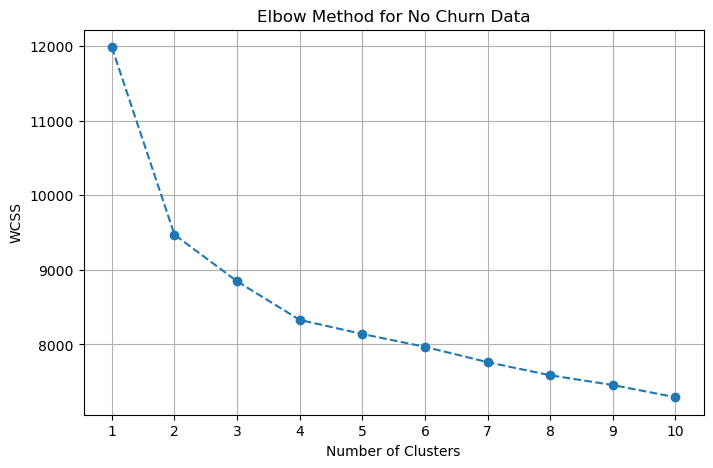

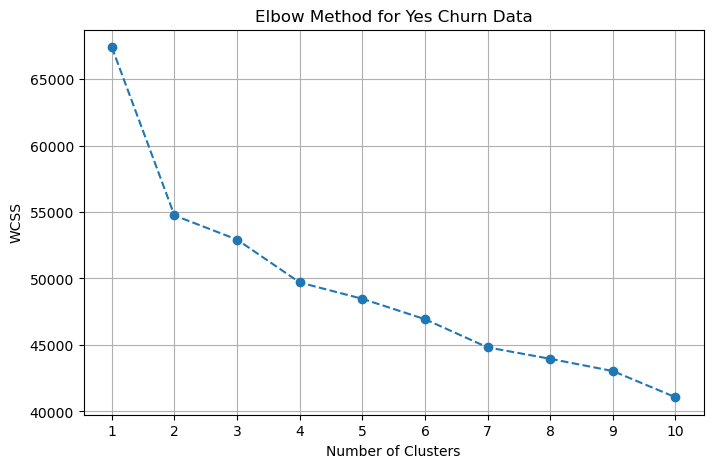

In [9]:
#split up the churning and on-churning observations for clustering
nochurndf = df_churn[df_churn["Response"] == 1]
yeschurndf = df_churn[df_churn["Response"] == 0]

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#elbow method for selecting the appropriate amount of clusters
def plot_elbow_method(df, max_clusters=10, title="Elbow Method"):
    # Drop 'Response' if present
    if 'Response' in df.columns:
        df = df.drop(columns=['Response'])
    
    # Convert categorical columns to dummy variables
    df = pd.get_dummies(df, drop_first=True)
    
    # Scale the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    # Compute WCSS for different numbers of clusters
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(df_scaled)
        wcss.append(kmeans.inertia_)
    
    # Plot the elbow graph
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
    plt.title(title)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.xticks(range(1, max_clusters + 1))
    plt.grid(True)
    plt.show()
# Apply the elbow method to nochurndf
plot_elbow_method(nochurndf, title="Elbow Method for No Churn Data")

# Apply the elbow method to yeschurndf
plot_elbow_method(yeschurndf, title="Elbow Method for Yes Churn Data")

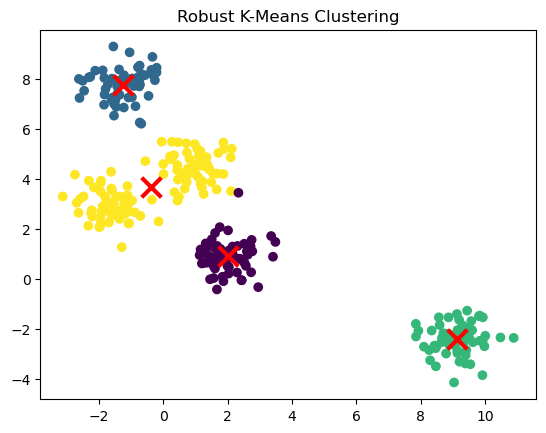

In [10]:
import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import euclidean_distances

class RobustKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=5, max_iter=100, tol=1e-4, lambda_param=1.0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.lambda_param = lambda_param

    def fit(self, X):
        n_samples, n_features = X.shape
        
        # Initialize centroids randomly
        self.centroids_ = X[np.random.choice(n_samples, self.n_clusters, replace=False)]
        
        for _ in range(self.max_iter):
            old_centroids = self.centroids_.copy()
            
            # Assign points to clusters
            distances = euclidean_distances(X, self.centroids_)
            labels = np.argmin(distances, axis=1)
            
            # Update centroids
            for k in range(self.n_clusters):
                cluster_points = X[labels == k]
                if len(cluster_points) > 0:
                    new_centroid = np.mean(cluster_points, axis=0)
                    
                    # Apply robustness constraint
                    max_distance = np.max(euclidean_distances(cluster_points, [new_centroid]))
                    if max_distance > self.lambda_param:
                        new_centroid = old_centroids[k] + self.lambda_param * (new_centroid - old_centroids[k]) / max_distance
                    
                    self.centroids_[k] = new_centroid
            
            # Check for convergence
            if np.all(np.abs(old_centroids - self.centroids_) < self.tol):
                break
        
        return self

    def predict(self, X):
        distances = euclidean_distances(X, self.centroids_)
        return np.argmin(distances, axis=1)
    
from sklearn.datasets import make_blobs

# Generate sample data
X, _ = make_blobs(n_samples=300, centers=5, cluster_std=0.60, random_state=0)

# Create and fit the model
robust_kmeans = RobustKMeans(n_clusters=4, lambda_param=2.0)
robust_kmeans.fit(X)

# Predict clusters
labels = robust_kmeans.predict(X)

# Visualize results (if working with 2D data)
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(robust_kmeans.centroids_[:, 0], robust_kmeans.centroids_[:, 1], marker='x', s=200, linewidths=3, color='r')
plt.title('Robust K-Means Clustering')
plt.show()